In [3]:
from utils.utils import *

In [5]:
train_data = load_data('hit-uav/images/train')
train_labels = load_labels('hit-uav/labels/train')

test_data = load_data('hit-uav/images/test')
test_labels = load_labels('hit-uav/labels/test')

val_data = load_data('hit-uav/images/val')
val_labels = load_labels('hit-uav/labels/val')

names = load_names('hit-uav/dataset.yaml')

Loading labels: 100%|██████████| 287/287 [00:00<00:00, 7754.97it/s]


## Data visualization

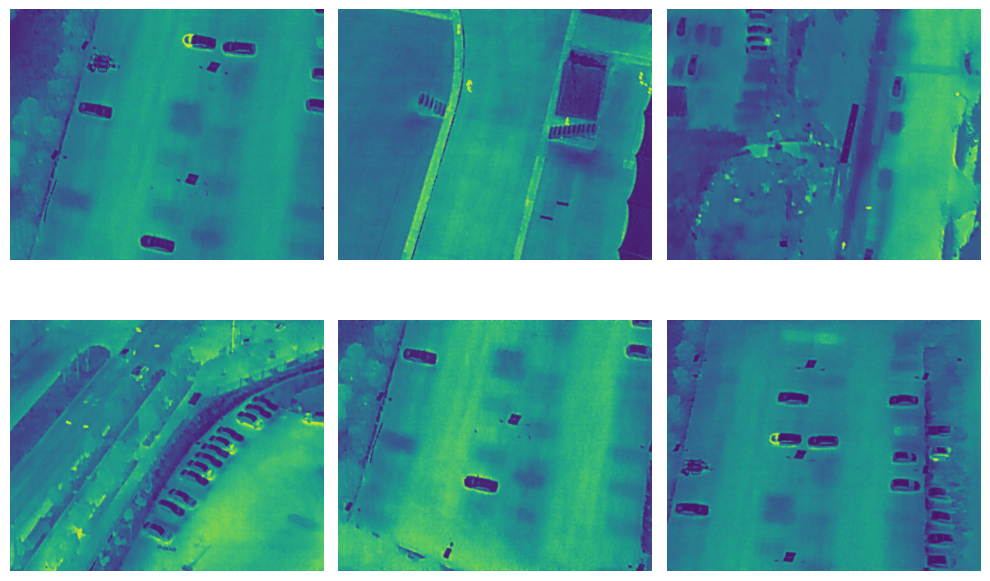

In [6]:

np.random.seed(42)  # For reproducibility
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, ax in enumerate(axes.flatten()):
    random_idx = np.random.randint(0, len(train_data))
    ax.imshow(train_data[random_idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

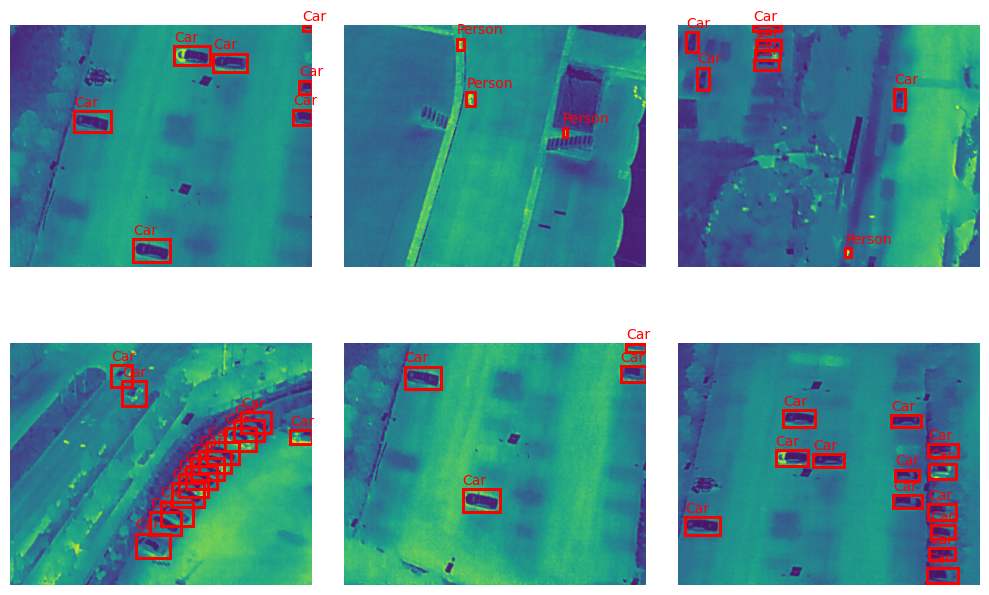

In [7]:
np.random.seed(42)  # For reproducibility
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, ax in enumerate(axes.flatten()):
    random_idx = np.random.randint(0, len(train_data))
    plot_with_labels(train_data[random_idx], train_labels[random_idx], names, ax)
plt.tight_layout()
plt.show()

In [8]:
unique_shapes = np.unique([img.shape for img in train_data], return_counts=True, axis=0)
print(unique_shapes)
unique_shapes = np.unique([img.shape for img in test_data], return_counts=True, axis=0)
print(unique_shapes)
unique_shapes = np.unique([img.shape for img in val_data], return_counts=True, axis=0)
print(unique_shapes)

(array([[512, 640]]), array([2008]))
(array([[512, 640]]), array([571]))
(array([[512, 640]]), array([287]))


In [9]:
all_train_labels = np.concatenate(train_labels, axis=0)
all_test_labels = np.concatenate(test_labels, axis=0)
all_val_labels = np.concatenate(val_labels, axis=0)

## Class distribution

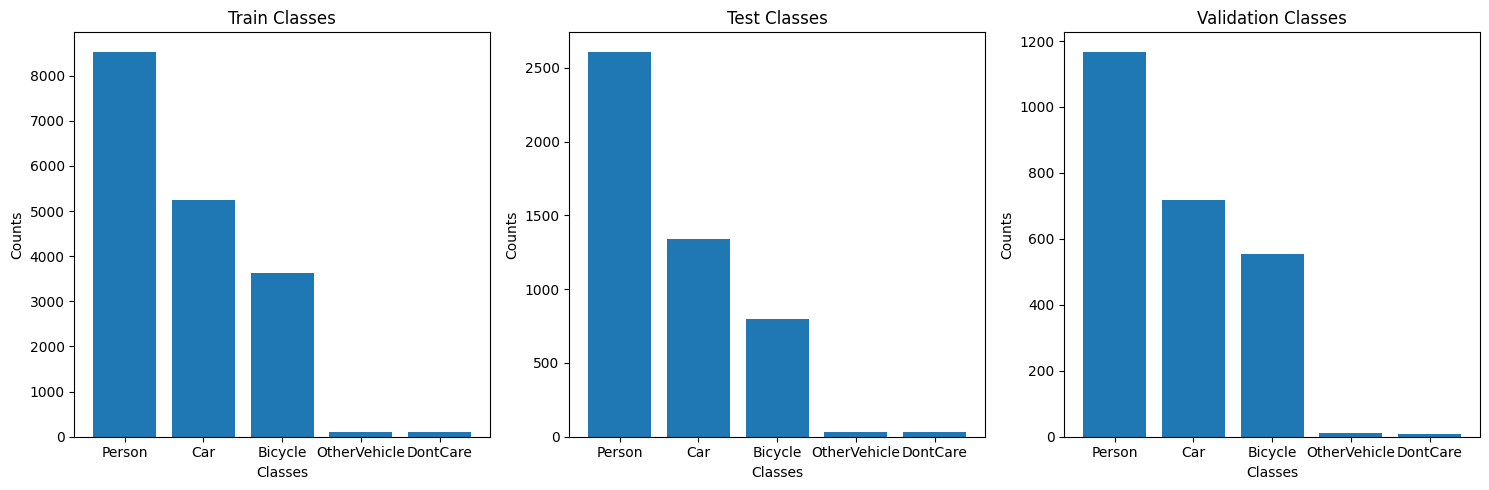

In [10]:
train_classes = np.unique(all_train_labels[:, 0], return_counts=True, axis=0)
test_classes = np.unique(all_test_labels[:, 0], return_counts=True, axis=0)
val_classes = np.unique(all_val_labels[:, 0], return_counts=True, axis=0)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].bar([names[cls] for cls in train_classes[0]], train_classes[1])
ax[0].set_title('Train Classes')
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Counts')
ax[1].bar([names[cls] for cls in test_classes[0]], test_classes[1])
ax[1].set_title('Test Classes')
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Counts')
ax[2].bar([names[cls] for cls in val_classes[0]], val_classes[1])
ax[2].set_title('Validation Classes')
ax[2].set_xlabel('Classes')
ax[2].set_ylabel('Counts')
plt.tight_layout()

plt.show()

## Bounding box size

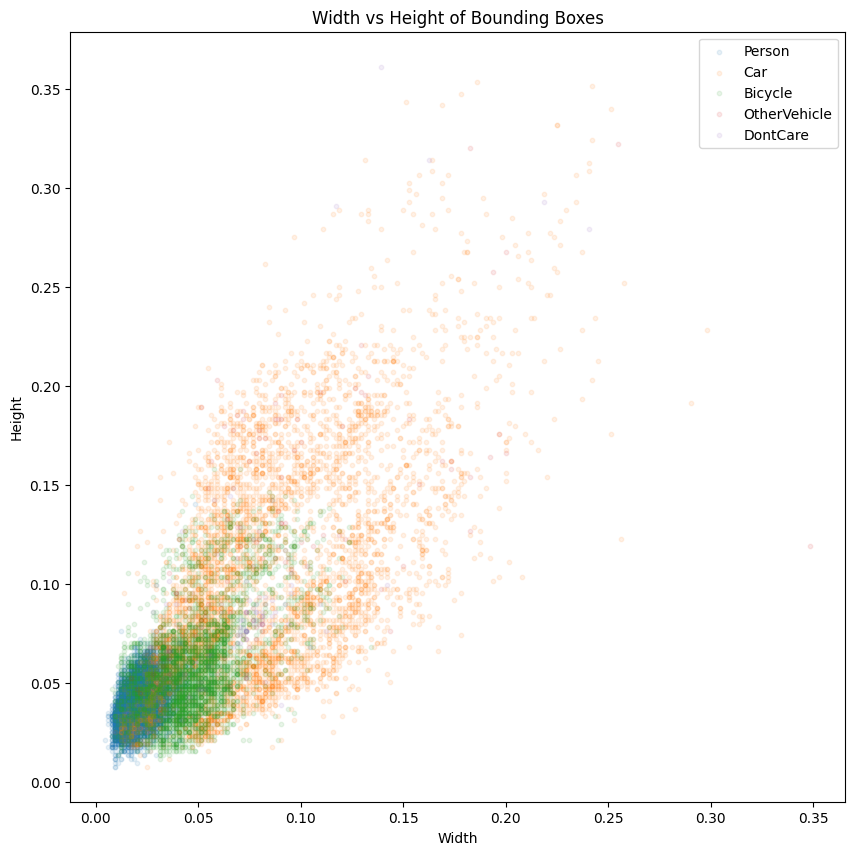

In [11]:
plt.figure(figsize=(10, 10))

# Plot with colors
for value, name in names.items():
    class_filter = all_train_labels[:, 0] == value
    plt.scatter(all_train_labels[class_filter, 3], all_train_labels[class_filter, 4], label=name, s=10, alpha=0.1)
    plt.xlabel('Width')
    plt.ylabel('Height')
plt.title('Width vs Height of Bounding Boxes')
plt.legend()
plt.show()

In [12]:
from collections import Counter

train_class_counts = []
for label in train_labels:
    class_counts = Counter(label[:, 0])
    class_counts = list(class_counts[i] for i in range(3))
    train_class_counts.append(class_counts)
train_class_counts = np.array(train_class_counts)

## Class correlation

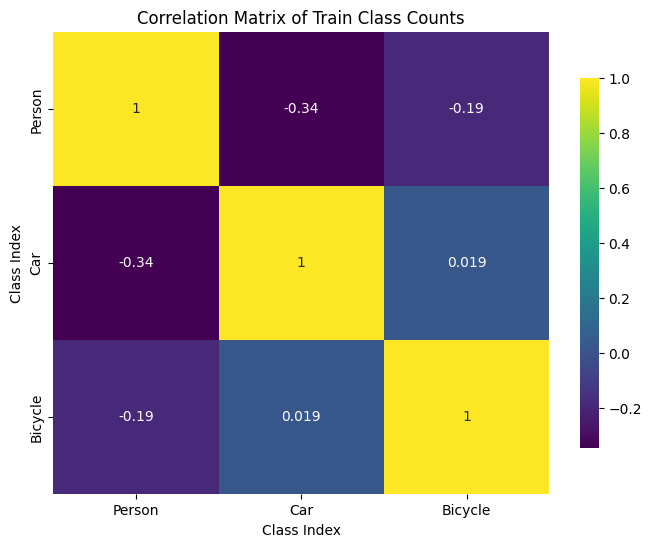

In [13]:
import seaborn as sns

# Compute the correlation matrix
correlation_matrix = np.corrcoef(train_class_counts, rowvar=False)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis',
            xticklabels=[names[i] for i in range(3)], yticklabels=[names[i] for i in range(3)], 
            cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Train Class Counts')
plt.xlabel('Class Index')
plt.ylabel('Class Index')
plt.show()

In [14]:
# Calculate the brightness histogram
histogram = np.zeros(256, dtype=int)
for image in train_data:
    brightness, counts = np.unique(image, return_counts=True)
    histogram[brightness] += counts

histogram = histogram / np.sum(histogram)  # Normalize the histogram

In [15]:
histogram_person = np.zeros(256, dtype=int)
histogram_car = np.zeros(256, dtype=int)
histogram_bike = np.zeros(256, dtype=int)

for image, labels in zip(train_data, train_labels):
    for label in labels:
        label, x_center, y_center, width, height = label[:5]
        x_center *= image.shape[1]
        y_center *= image.shape[0]
        width *= image.shape[1]
        height *= image.shape[0]
        brightness, counts = np.unique(
            image[int(x_center - width // 2):int(x_center + width // 2),
                    int(y_center - height // 2):int(y_center + height // 2)], 
                return_counts=True)   
        if label == 0:
            histogram_person[brightness] += counts
        elif label == 1:
            histogram_car[brightness] += counts
        elif label == 2:
            histogram_bike[brightness] += counts

histogram_person = histogram_person / np.sum(histogram_person)  
histogram_car = histogram_car / np.sum(histogram_car)  
histogram_bike = histogram_bike / np.sum(histogram_bike) 

## Histogram of classes comparison

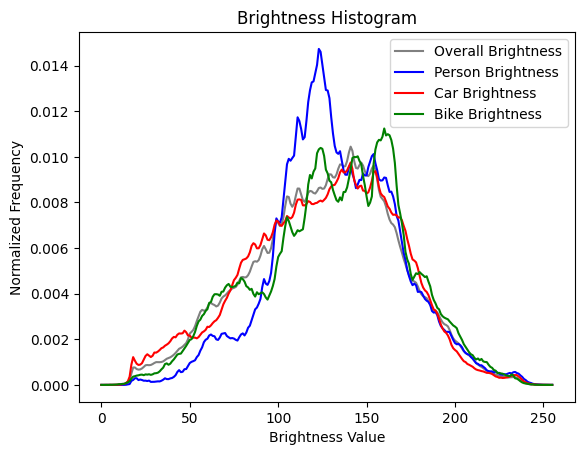

In [16]:
plt.plot(range(256), histogram, color='gray', label='Overall Brightness')
plt.plot(range(256), histogram_person, color='blue', label='Person Brightness')
plt.plot(range(256), histogram_car, color='red', label='Car Brightness')
plt.plot(range(256), histogram_bike, color='green', label='Bike Brightness')
plt.title('Brightness Histogram')
plt.xlabel('Brightness Value')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.show()
